In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np

In [2]:
# Paakhi
# conn = psycopg2.connect(
#     host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
#     port='5432',
#     user='paakhi_b014108f50994e35ab8fa4e2dc26d612',
#     password='paakhi_b014108f50994e35ab8fa4e2dc26d612_password',
#     database='paakhi_b014108f50994e35ab8fa4e2dc26d612_db'
# )

conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

In [3]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [4]:
data = pd.read_sql(query1, conn)

<ipython-input-4-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [5]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [6]:
data[data["product_id"] == np.nan]

,order_id,order_date,user_id,product_id,product_name,order_status,quantity,sp


In [7]:
data['WeekCount']=data['order_date'].dt.strftime('%y-w%U')

In [8]:
data = data.dropna()

In [9]:
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()

In [10]:
WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:3]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [11]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [12]:
List=output_list
productsegstats_weekly = {}


for x in List:
  x3 = data[data["WeekCount"] <= x]
  totalcarts=x3['order_id'].nunique()
  productlevel=x3.groupby(['product_id','product_name']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
      ).reset_index()
  productlevel['CartPenetration']=productlevel['Carts']/totalcarts
  productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
  productlevel['QpC']=productlevel['quantity']/productlevel['Carts']
  productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

  CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

  productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
  productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
  productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
  productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
  productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']

  def ProductCohortLables(df):
      if df['SumScore'] > 15:
          return 'Hero Products'
      elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
          return 'Marquee & New Business Drivers'
      elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
          return 'Marquee & Repeat Business Drivers'

      elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
          return 'High Value & Slow Moving'
      elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
          return 'Low Value & Slow Moving'
      else:
          return 'Lagging Products'

  productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)

  merged_df = pd.merge(productlevel, data, on=['product_id', 'product_name', 'quantity', 'AOVContribution'], how='left')

  productsegstats=merged_df.groupby('Product Cohort Lables').agg(
        ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
        Orders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
        AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
        ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
        NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
        RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
        Users=pd.NamedAgg(column='user_id', aggfunc='nunique'))
  productsegstats["QuantityperCart"] = productsegstats["Quantity"] / productsegstats["Orders"]
  productsegstats["CartPenetration"] = productsegstats["Orders"] / productsegstats["Orders"].sum()
  productsegstats["NewUserRatio"] = productsegstats["NewOrders"] / productsegstats["Users"].sum()
  productsegstats["ASPXQpC"] = productsegstats["QuantityperCart"] * productsegstats["ASP"]
  product_cohort_labels = ['Hero Products', 'Marquee & New Business Drivers', 'Marquee & Repeat Business Drivers', 'High Value & Slow Moving', 'Low Value & Slow Moving', 'Lagging Products']
  dummy_df = pd.DataFrame(index=product_cohort_labels, columns=productsegstats.columns.tolist())
  for i in product_cohort_labels:
    try:
      dummy_df.loc[i] = productsegstats.loc[i]
    except:
      pass
    dummy_df = dummy_df.fillna(0)
    productsegstats_weekly[x] = dummy_df
productsegstats

,ProductCount,Orders,AOVContribution,Quantity,ASP,NewOrders,RepeatOrders,Users,QuantityperCart,CartPenetration,NewUserRatio,ASPXQpC
Product Cohort Lables,,,,,,,,,,,,
High Value & Slow Moving,7,10,0.666330,17,2471.818182,0.0,11.0,9,1.700000,0.060241,0.000000,4202.090909
Lagging Products,100,156,124.870574,5855,1448.664706,117.0,53.0,152,37.532051,0.939759,0.726708,54371.358032
Marquee & New Business Drivers,4,0,95.233468,16735,NaN,0.0,0.0,0,inf,0.000000,0.000000,NaN
Marquee & Repeat Business Drivers,52,0,760.021999,66620,NaN,0.0,0.0,0,inf,0.000000,0.000000,NaN


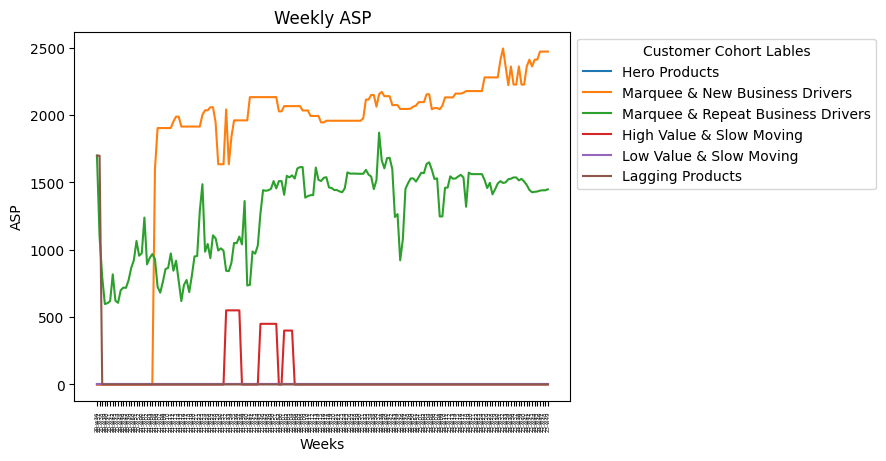

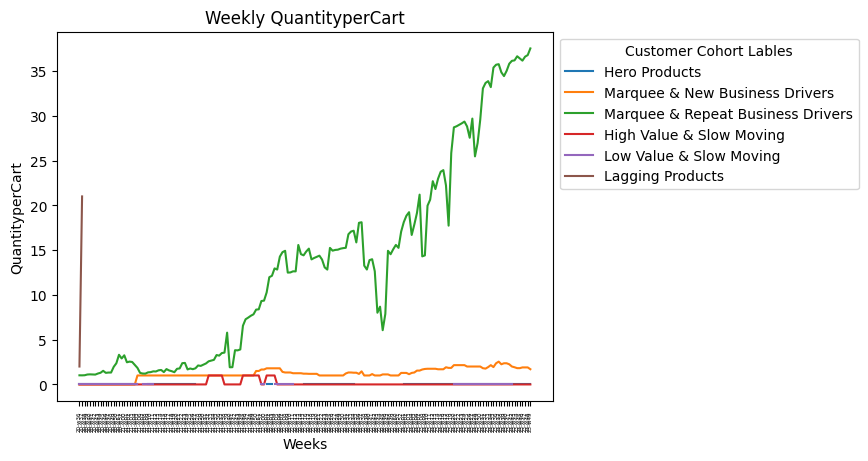

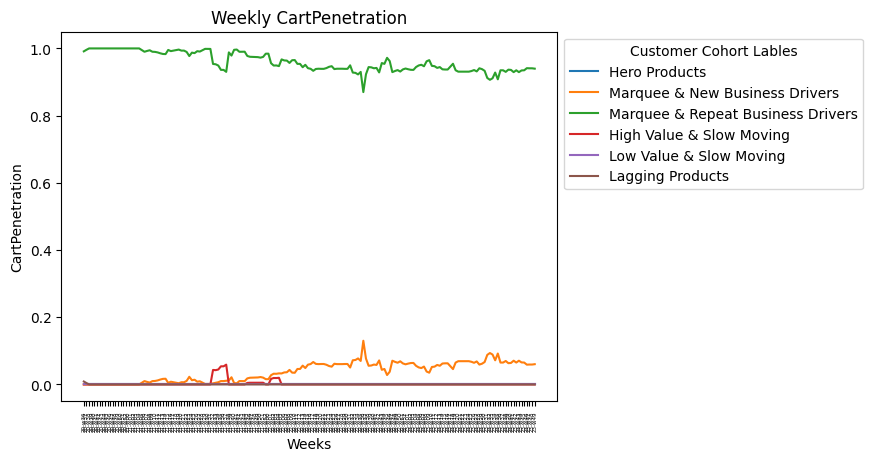

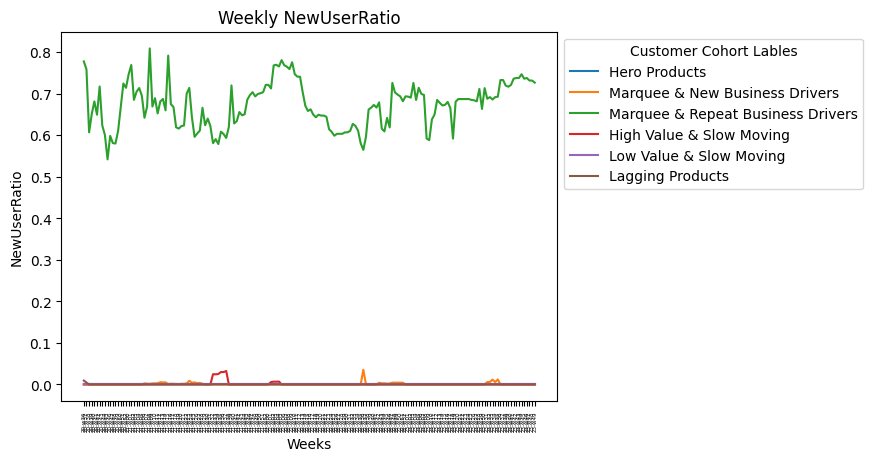

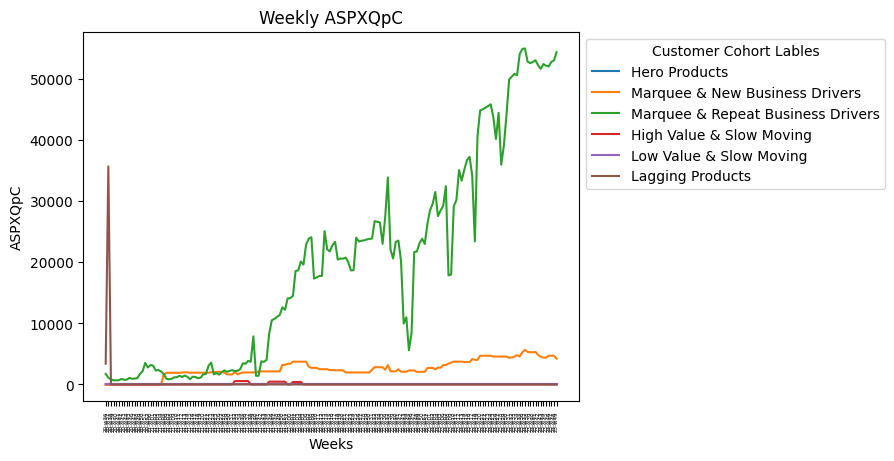

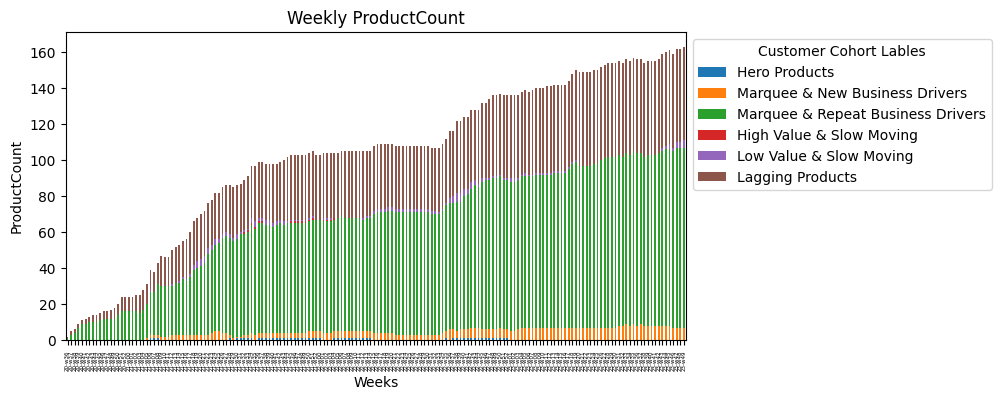

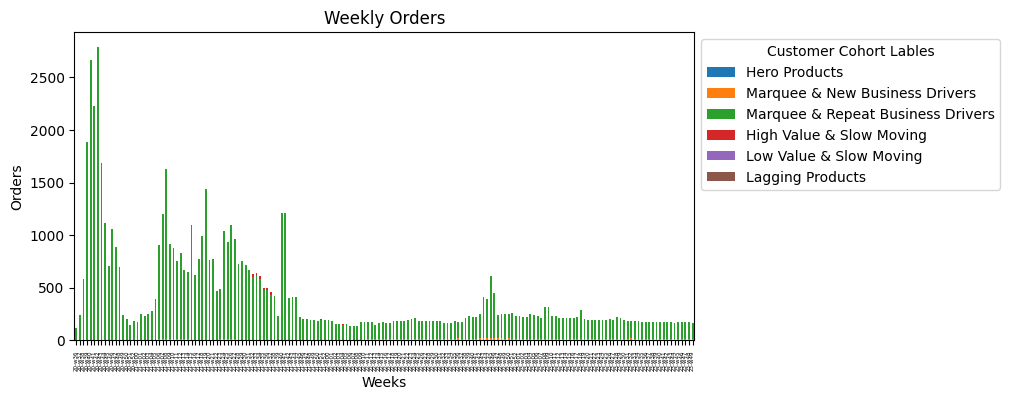

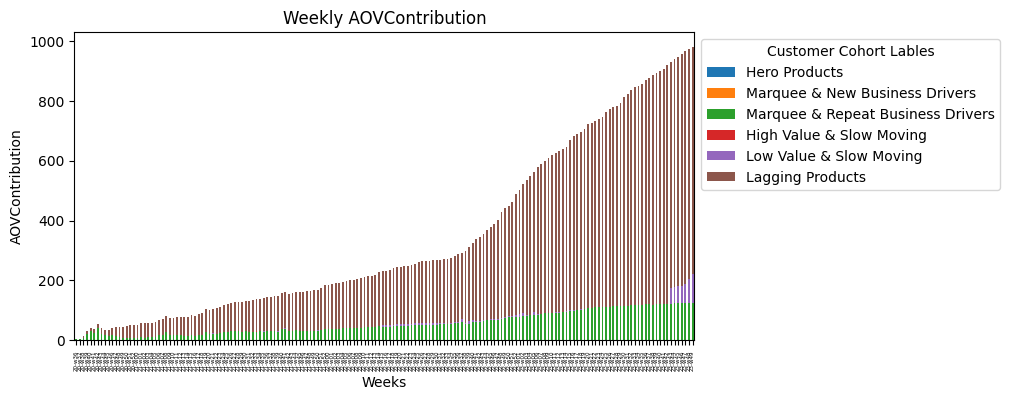

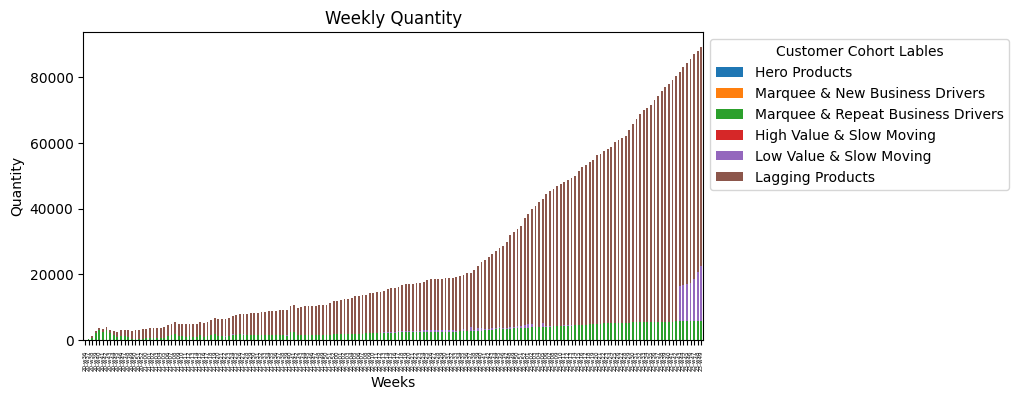

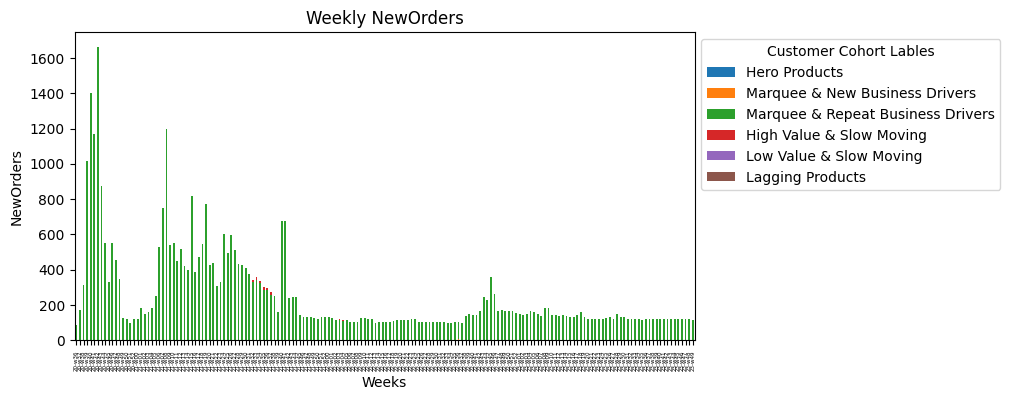

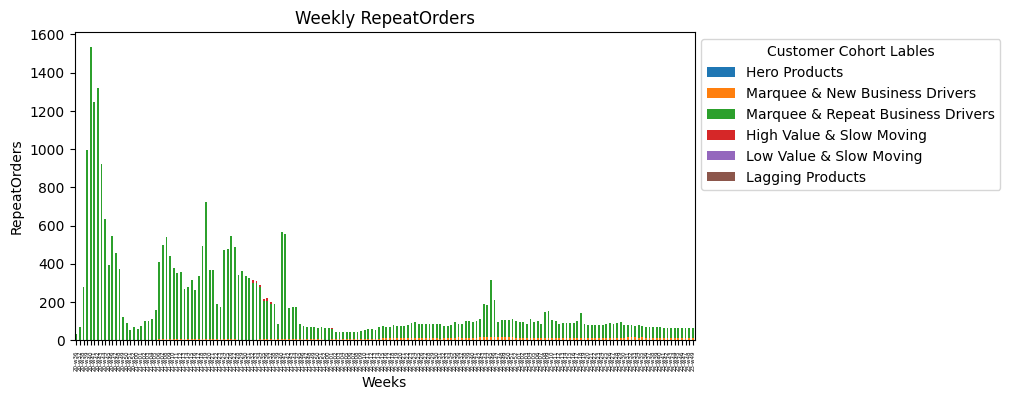

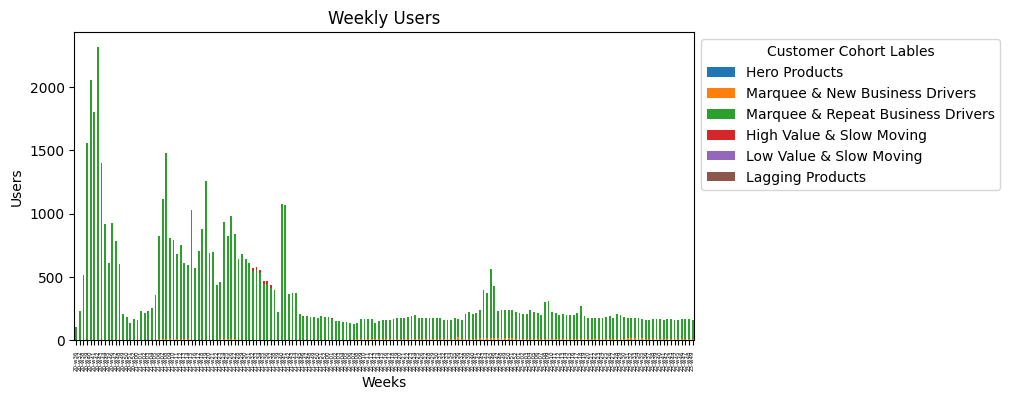

In [13]:
each_metric_df = {}
ListofCustomerCohortVariables = productsegstats.columns.to_list()
Line_Chart_Variable_List_Product = ['ASP', 'QuantityperCart', 'CartPenetration', 'NewUserRatio', 'ASPXQpC']
Stack_Chart_Variable_List_Product = ['ProductCount', 'Orders', 'AOVContribution', 'Quantity', 'NewOrders', 'RepeatOrders', 'Users']
for week, df in productsegstats_weekly.items():
    df.sort_index(inplace=True)

for x in Line_Chart_Variable_List_Product:
  column_df = pd.DataFrame({week: df[x].tolist() for week, df in productsegstats_weekly.items()})
  column_df.index = product_cohort_labels
  column_transposed = column_df.transpose()
  each_metric_df[x] = column_transposed
  weeks = column_transposed.index.to_list()
  for column_name, values in column_transposed.items():
    plt.plot(weeks, values, label=column_name)
  plt.xlabel('Weeks')
  plt.ylabel(x)
  plt.title(f'Weekly {x}')
  plt.xticks(fontsize=4, rotation=90)
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
  plt.show()
  plt.savefig('m.png')

for x in Stack_Chart_Variable_List_Product:
  variable_df = pd.DataFrame({week: df[x].tolist() for week, df in productsegstats_weekly.items()})
  variable_df.index = product_cohort_labels
  variable_df_transposed = variable_df.transpose()
  each_metric_df[x] = variable_df_transposed
  graph2 = variable_df_transposed
  graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
  plt.title(f'Weekly {x}')
  plt.xticks(fontsize=4)
  plt.xlabel('Weeks')
  plt.ylabel(x)
  plt.legend(loc='upper left', bbox_to_anchor=(1,1), title = 'Customer Cohort Lables')
  plt.show()


In [14]:
each_metric_df


{'ASP':         Hero Products  Marquee & New Business Drivers  \
 20-w36            0.0                        0.000000   
 20-w37            0.0                        0.000000   
 20-w38            0.0                        0.000000   
 20-w39            0.0                        0.000000   
 20-w40            0.0                        0.000000   
 ...               ...                             ...   
 23-w45            0.0                     2412.083333   
 23-w46            0.0                     2471.818182   
 23-w47            0.0                     2471.818182   
 23-w48            0.0                     2471.818182   
 23-w49            0.0                     2471.818182   
 
         Marquee & Repeat Business Drivers  High Value & Slow Moving  \
 20-w36                        1699.000000                       0.0   
 20-w37                        1095.352459                       0.0   
 20-w38                         796.515152                       0.0   
 20-w39

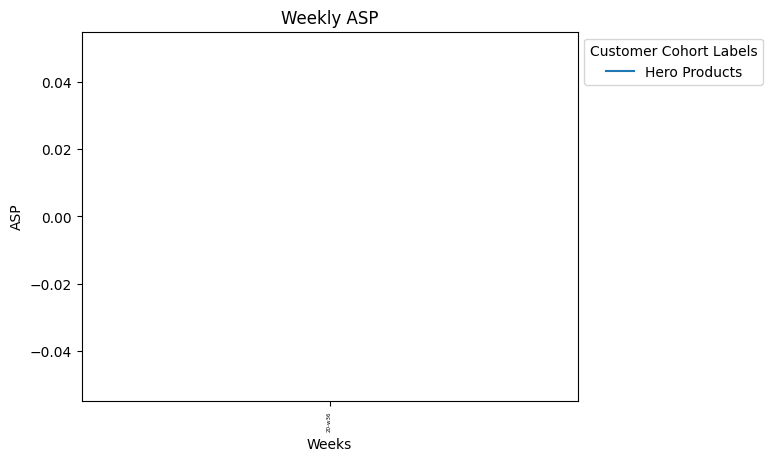

In [15]:
def metric_cohort_graph(metric, cohort):
    if metric in Line_Chart_Variable_List_Product:
        column_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        column_df.index = product_cohort_labels
        column_transposed = column_df.transpose()
        each_metric_df[metric] = column_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        plt.plot(column_transposed.index, each_metric_df[metric], label=cohort)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4, rotation=90)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

    if metric in Stack_Chart_Variable_List_Product:
        variable_df = pd.DataFrame({week: df[metric].tolist() for week, df in productsegstats_weekly.items()})
        variable_df.index = product_cohort_labels
        variable_df_transposed = variable_df.transpose()
        each_metric_df[metric] = variable_df_transposed[cohort]  # Select only the specified cohort column

        # Replace zero values with np.nan
        each_metric_df[metric] = np.where(each_metric_df[metric] == 0, np.nan, each_metric_df[metric])

        graph2 = pd.DataFrame({cohort: each_metric_df[metric]})
        graph2.plot(kind='bar', stacked=True, figsize=(8, 4))
        plt.title(f'Weekly {metric}')
        plt.xticks(fontsize=4)
        plt.xlabel('Weeks')
        plt.ylabel(metric)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Customer Cohort Labels')
        plt.show()

# Call the function with the specified metric and cohort
result = metric_cohort_graph('ASP', 'Hero Products')